# Simple Question-Answering Agent Tutorial

## Overview
This tutorial introduces a basic Question-Answering (QA) agent using LangChain and OpenAI's language model. The agent is designed to understand user queries and provide relevant, concise answers.

## Motivation
In the era of AI-driven interactions, creating a simple QA agent serves as a fundamental stepping stone towards more complex AI systems. This project aims to:
- Demonstrate the basics of AI-driven question-answering
- Introduce key concepts in building AI agents
- Provide a foundation for more advanced agent architectures

## Key Components
1. **Language Model**: Utilizes OpenAI's GPT model for natural language understanding and generation.
2. **Prompt Template**: Defines the structure and context for the agent's responses.
3. **LLMChain**: Combines the language model and prompt template for streamlined processing.

## Method Details

### 1. Setup and Initialization
- Import necessary libraries (LangChain, dotenv)
- Load environment variables for API key management
- Initialize the OpenAI language model

### 2. Defining the Prompt Template
- Create a template that instructs the AI on its role and response format
- Use the PromptTemplate class to structure the input

### 3. Creating the LLMChain
- Combine the language model and prompt template into an LLMChain
- This chain manages the flow from user input to AI response

### 4. Implementing the Question-Answering Function
- Define a function that takes a user question as input
- Adding memory to maintain context across multiple questions
- Use the LLMChain to process the question and generate an answer


### 5. User Interaction
- In a Jupyter notebook environment, provide cells for:
  - Example usage with a predefined question
  - Interactive input for user questions

## Conclusion
This Simple Question-Answering Agent serves as an entry point into the world of AI agents. By understanding and implementing this basic model, you've laid the groundwork for more sophisticated systems. Future enhancements could include:
- Integrating external knowledge bases for more informed responses
- Implementing more complex decision-making processes

As you progress through more advanced tutorials in this repository, you'll build upon these fundamental concepts to create increasingly capable and intelligent AI agents.

### Import necessary libraries


In [1]:
from langchain.chat_models import init_chat_model
from langchain_core.prompts import PromptTemplate

In [ ]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv(dotenv_path="../.env", verbose=True)

# # Retrieve the key
# openai_key = os.getenv('OPENAI_API_KEY')

# # Check if it exists
# if openai_key:
#     print(f"API Key found: {openai_key}")
# else:
#     print("API Key not found. Please check your .env file.")

True

### initialize the language model

In [2]:
# Instantiate
llm = init_chat_model(
    model="gpt-4.1-nano",
    max_tokens=1000, # Output cuttoff once output reaches 1000 tokens/request
    temperature=0, # Deterministic
    timeout=None,
    max_retries=2
    )

### Define the prompt template

In [4]:
template = """
You are a helpful AI assistant. Your task is to answer the user's question to the best of your ability.

User's question: {question}

Please provide a clear and concise answer:
"""

prompt = PromptTemplate(template=template, input_variables=["question"])

### Create the LLMChain

In [5]:
qa_chain = prompt | llm

### Define the get_answer function

In [6]:
def get_answer(question):
    """
    Get an answer to the given question using the QA chain.
    """
    input_variables = {"question": question}
    response = qa_chain.invoke(input_variables).content
    return response

### Cell 6: Example usage

In [7]:
question = "What is the capital of France?"
answer = get_answer(question)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: What is the capital of France?
Answer: The capital of France is Paris.


Pass the PromptTemplate output, populated with the user’s input key, as the input to the ChatOpenAI model invocation.

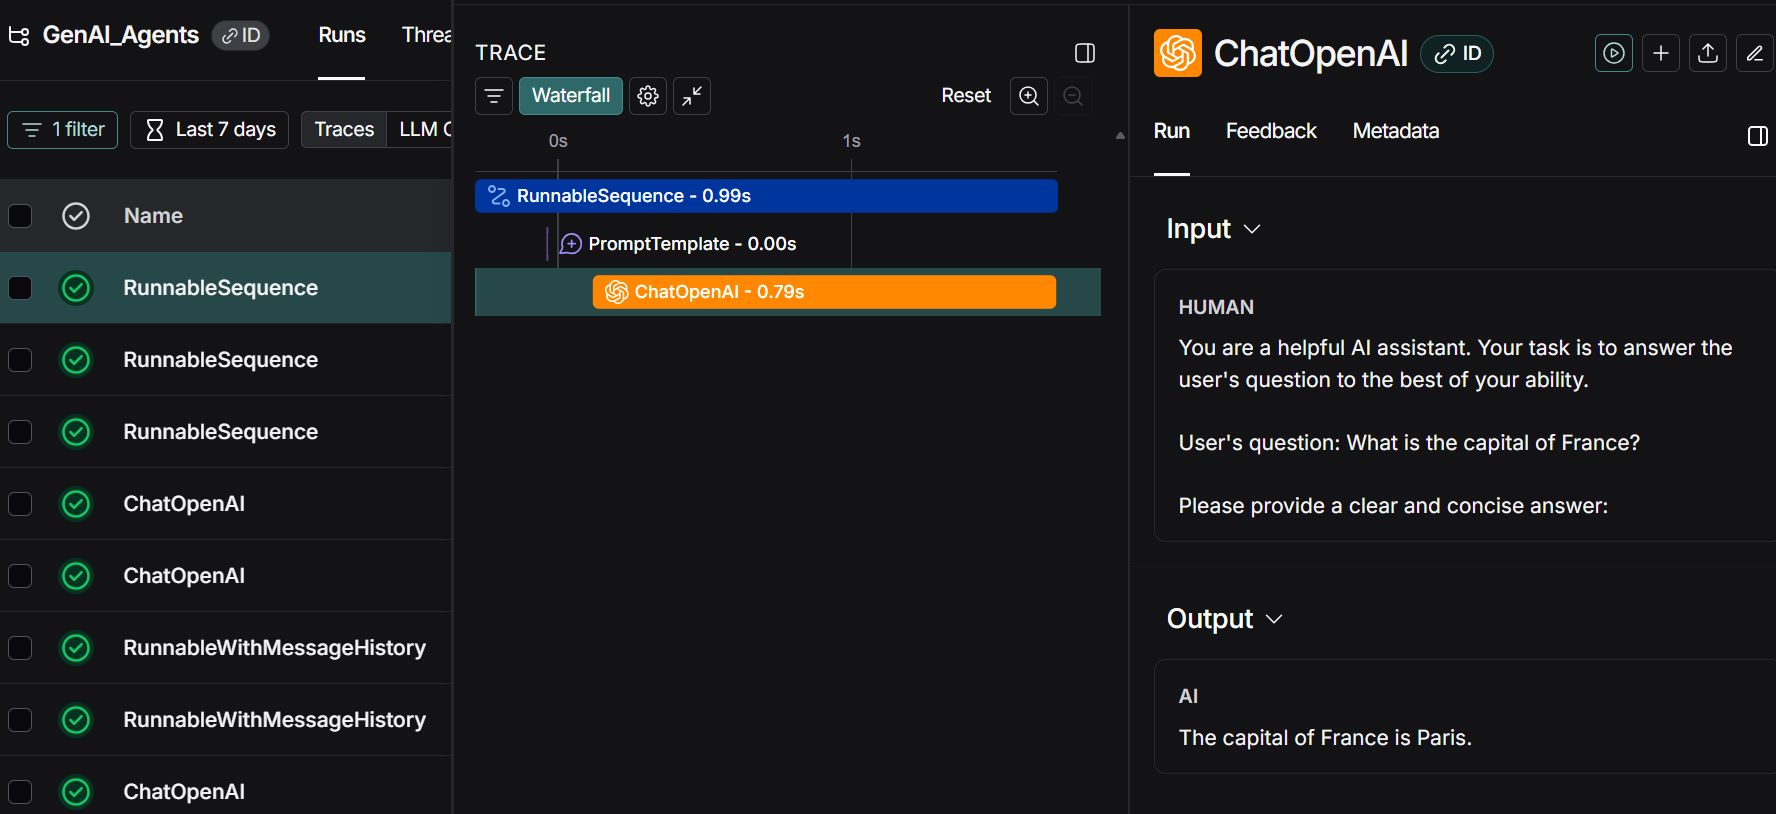

### Interactive cell for user questions

In [8]:
while True:
    user_question = input("Enter your question: ")
    if user_question.lower()=="quit":
        break
    user_answer = get_answer(user_question)
    print(f"Answer: {user_answer}")

Answer: The capital of India is New Delhi.
Answer: Your previous message was: "You are a helpful AI assistant. Your task is to answer the user's question to the best of your ability."


Since the trace shows the LLM isn’t preserving prior Q&A state, we’ll build a program to persist context and inject it into each new request.

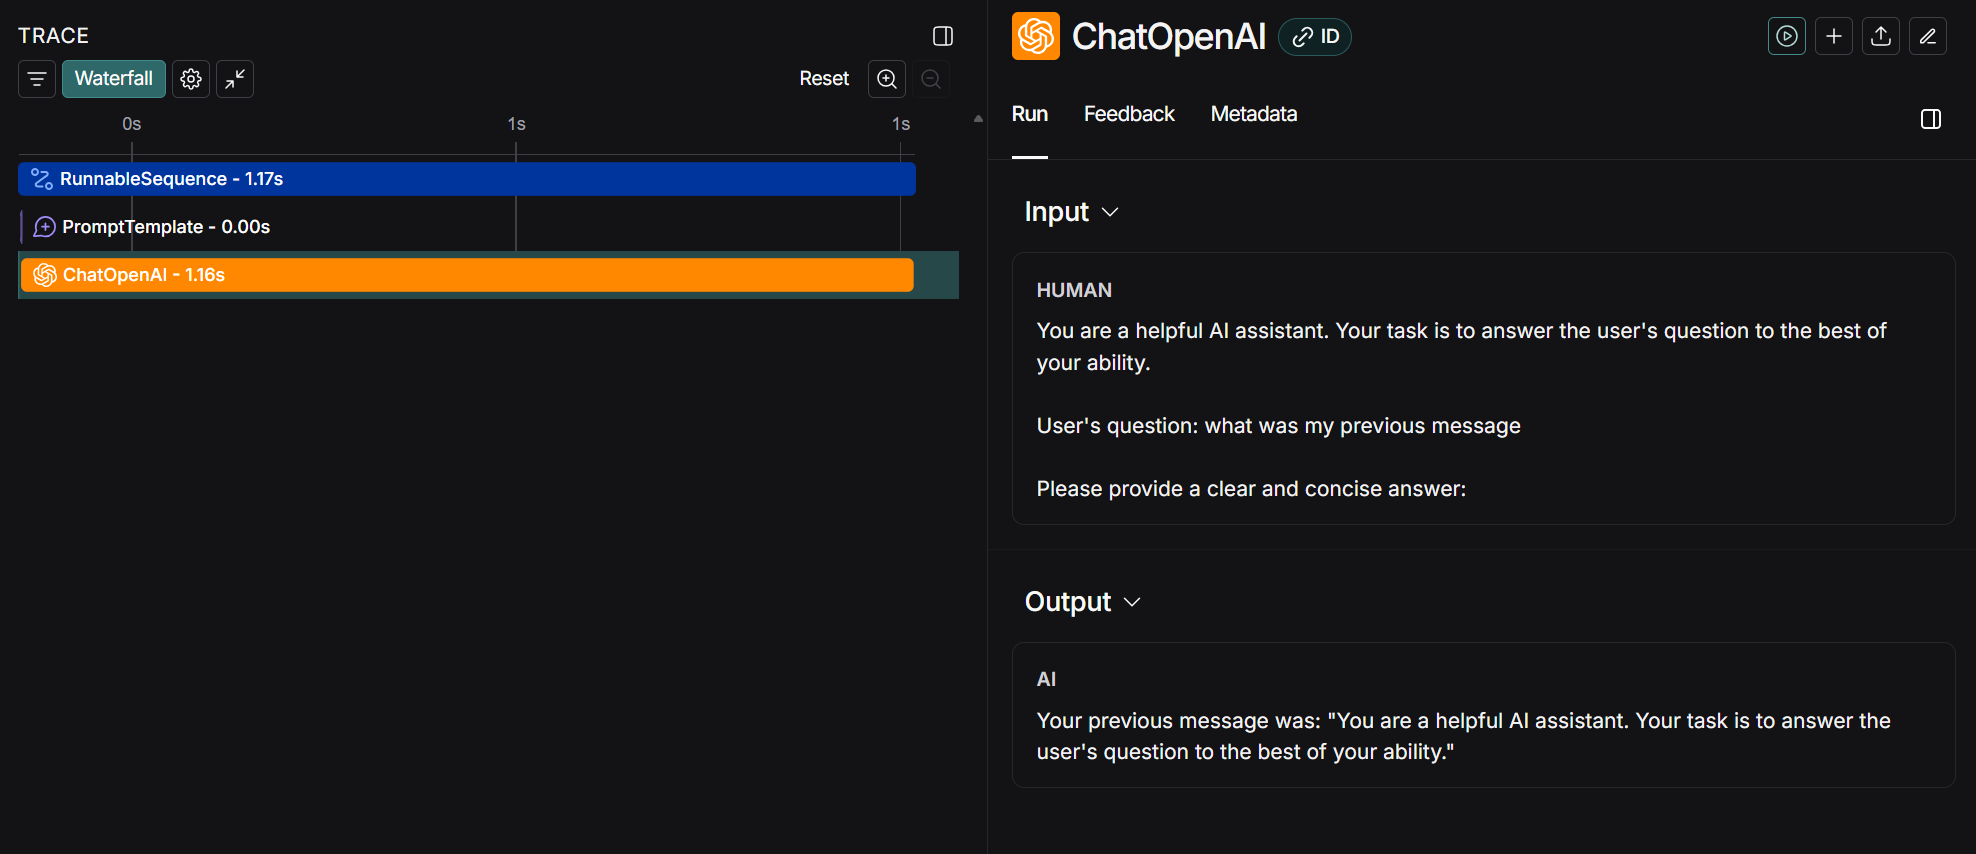

# Approach 2

LangChain’s Built‑in Chat History that has RunnableWithMessageHistory that automatically store and feed past messages to the LLM.

In [9]:
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langchain.prompts import PromptTemplate
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.memory import ChatMessageHistory

# Load environment variables
load_dotenv(dotenv_path="../.env", verbose=True)

# 1. Create the base LLM
llm = init_chat_model(
    model="gpt-4.1-nano",
    max_tokens=1000,
    temperature=0,
    timeout=None,
    max_retries=2
)

# 2. Define your prompt template
template = """
You are a helpful AI assistant. Continue the conversation using the full context.
Your task is to answer the user's question to the best of your ability.

{history}
User's question: {question}
AI:

Please provide a clear and concise answer:
"""
prompt = PromptTemplate(
    template=template,
    input_variables=["history", "question"]
)

# 3. Wrap the prompt + LLM into a chain
qa_chain = prompt | llm

# 4. Create a session store for histories
session_store = {}

def get_session_history(session_id: str) -> ChatMessageHistory:
    """Retrieve or create a ChatMessageHistory for a given session_id."""
    if session_id not in session_store:
        session_store[session_id] = ChatMessageHistory()
    return session_store[session_id]

# 5. Wrap the chain with RunnableWithMessageHistory
with_history = RunnableWithMessageHistory(
    runnable=qa_chain,
    get_session_history=get_session_history,
    input_messages_key="question",     # key for the new user input
    history_messages_key="history"     # key where history will be injected
)

# 6. Chat loop
SESSION_ID = "user_123"  # could be dynamic per user

while True:
    user_question = input("Enter your question: ")
    if user_question.lower() == "quit":
        break

    # Invoke with session_id so history is preserved
    response = with_history.invoke(
        {"question": user_question},
        config={"configurable": {"session_id": SESSION_ID}}
    )

    print(f"Answer: {response.content}")


Answer: The capital of France is Paris.
Answer: Your previous message was: "what is the capital of France"


Using persisted session memory, previous exchanges are saved and injected into subsequent requests to maintain context.

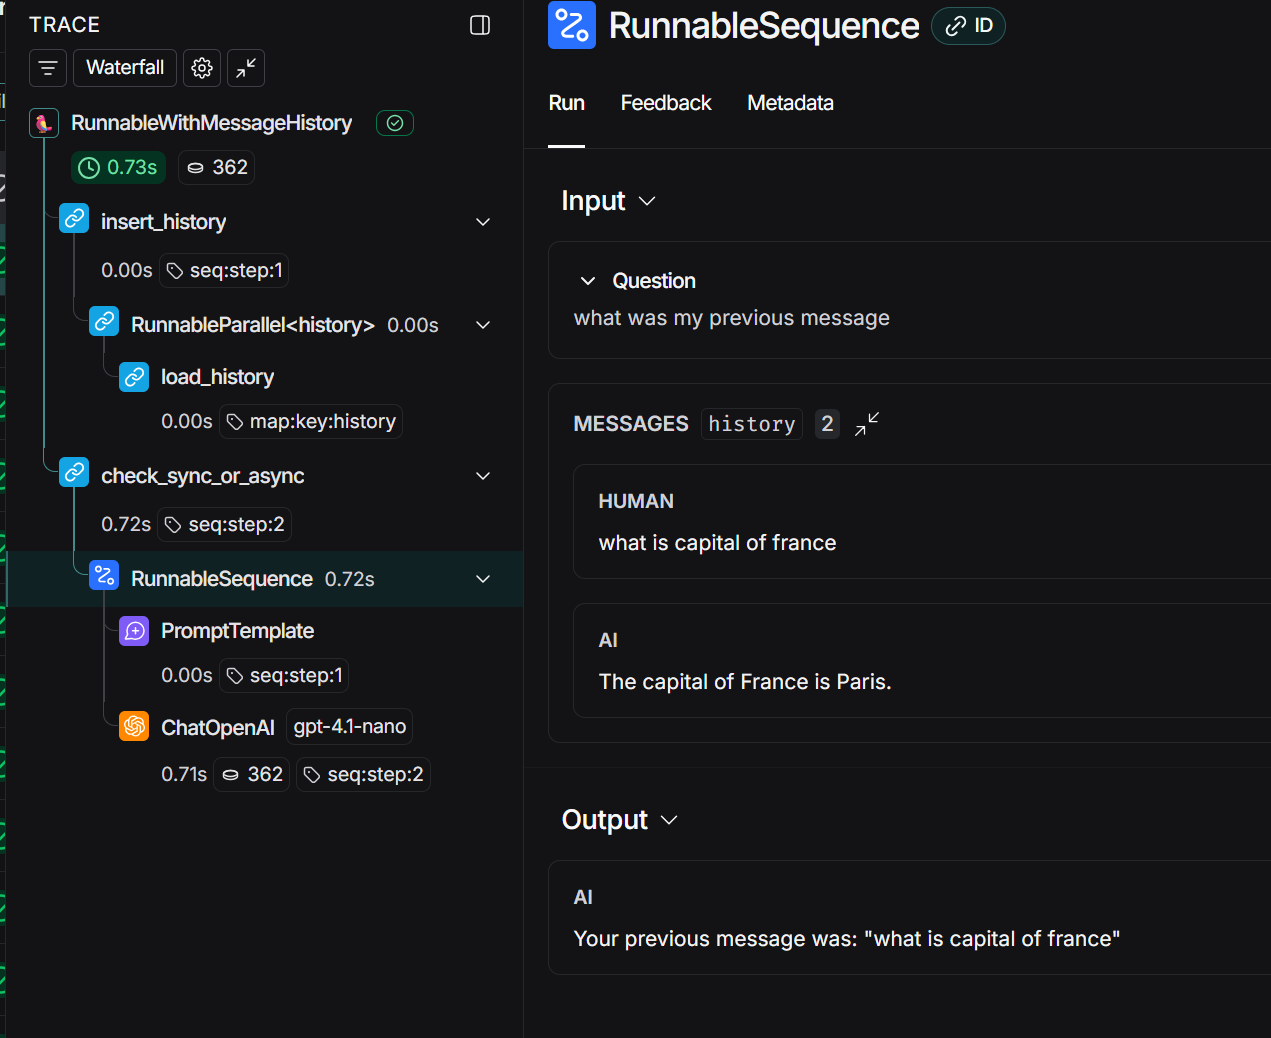

### Approach 3:short-term memory (thread-level persistence) 

Specify a checkpointer when creating an agent.

LangChain’s agent manages short-term memory as a part of your agent’s state.Short-term memory updates when the agent is invoked or a step is completed, and the state is read at the start of each step.

Note: Below code only works with v1-alpha release which is not official release version as  v1.0 will be released in October 2025.

Current version we used in the code above is v0 .Please refer requirements.txt file for current installed versions. Hence below code cannot be tested with current version

You can create a seperate virtualenvironment by installing below versions and test below code 
- pip install --pre -U langchain
- pip install --pre -U langchain-core
- pip install --pre -U langchain-openai
- pip install --pre -U langgraph

In [26]:
from dotenv import load_dotenv
from langchain.agents import create_agent
from langgraph.checkpoint.memory import InMemorySaver

load_dotenv(dotenv_path="../.env", verbose=True)

# Create the agent with checkpointing
agent = create_agent(
    "openai:gpt-5-nano",
    tools=[],
    checkpointer=InMemorySaver(),
)

THREAD_ID = "user_123"

while True:
    user_question = input("Enter your question: ")
    if user_question.lower() == "quit":
        break

    # Pass the question directly to the agent
    response = agent.invoke(
        {"messages": [("user", user_question)]},
        config={"configurable": {"thread_id": THREAD_ID}}
    )
    print(response['messages'][-1].content)


Paris.
Your previous message was: "what is capital of france"


The agent automatically saves and reuses prior messages for context.

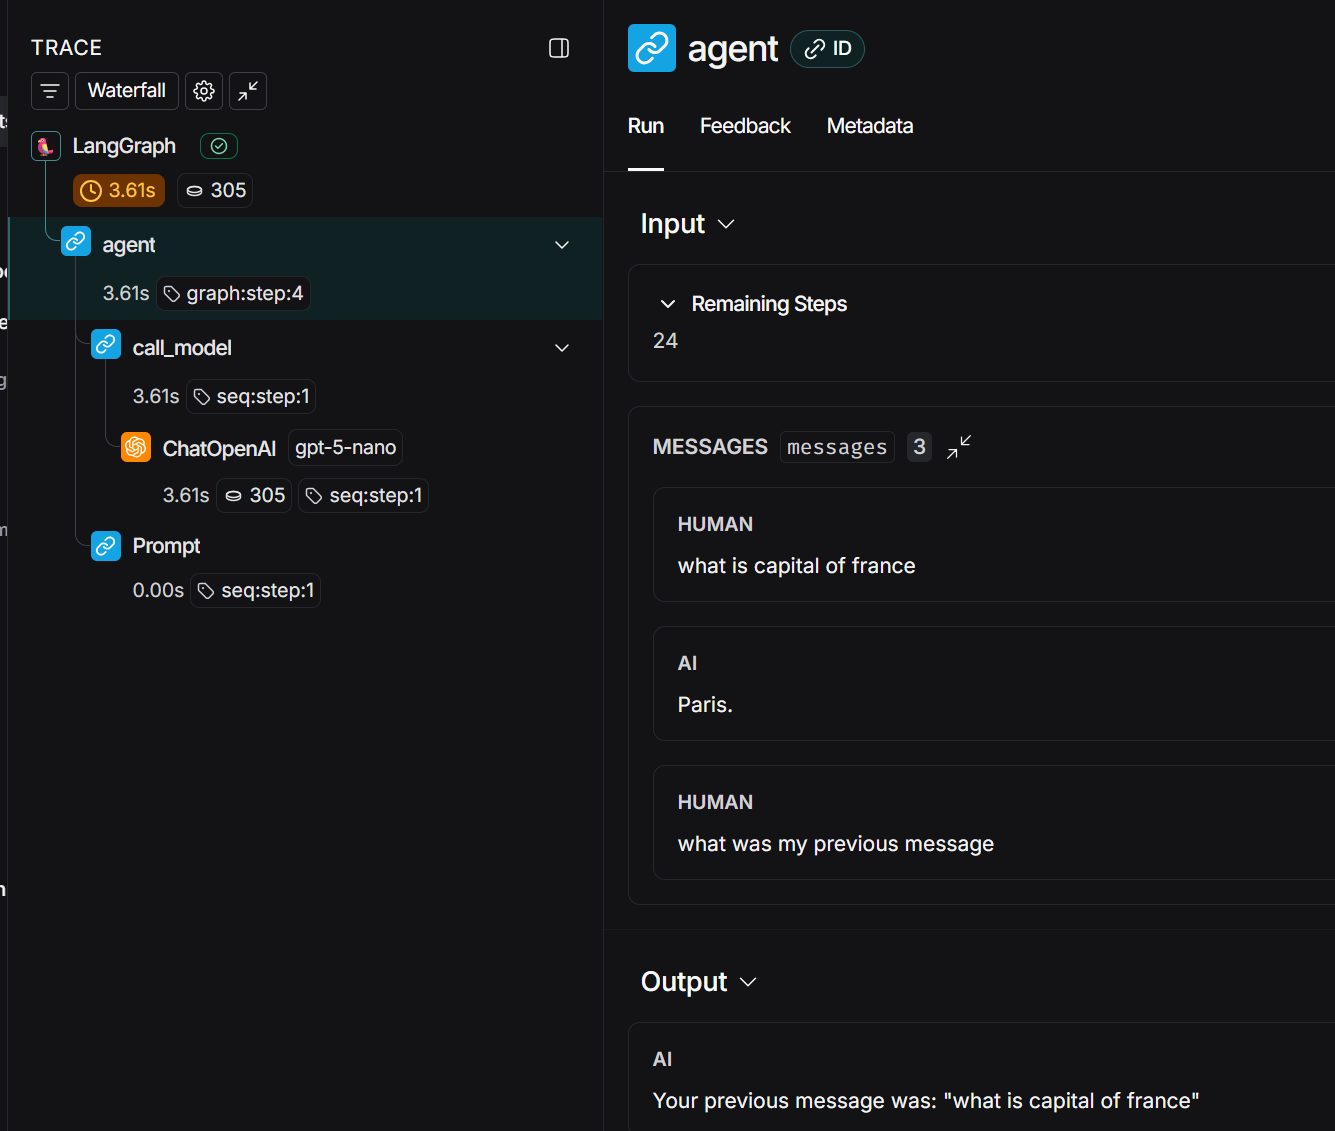